In [2]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image, ImageDraw
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def scale_to_range(array, new_min=0, new_max=380):
    old_min = np.min(array)
    old_max = np.max(array)
    
    scaled_array = new_min + ((array - old_min) * (new_max - new_min) / (old_max - old_min))
    return scaled_array

# WHAT TO DO WITH THE INPUT:
# STARTING FROM IMAGE_ID AND 4 PARAMETERS FOR BBOX
# DIVIDE THE IMAGE IN GRID SIZE (128 -> 16, 8 AND 4)
# CALCULATE THE CENTER OF THE OBJECTS IN THE IMAGE BY CALCULATING THE CENTER OF THE BOUNDING BOX -> WE HAVE IT
# CALCULATE THE CELL IN WHICH THE CENTER LIES: THAT IS THE CELL RESPONSIBLE OF CALCULATING THE BBOX
# TRANSFORM THE XYWH QUANTITIES IN DELTA_X DELTA_Y DELTA_W DELTA_H 
# ADD CONFIDENCE 100% AND CLASS PROBABILITY 1 (CAR) FOR THAT GRID
# PUT ALL ZEROS IN ALL THE OTHER CELLS IN WHICH WE DON'T HAVE OBJECTS
class YOLODataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = self.annotations['image'].unique()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, image_id)
        image = Image.open(img_path).convert("RGB")
                     
        boxes = self.annotations[self.annotations['image'] == image_id][['xmin', 'ymin', 'xmax', 'ymax']].values
        #print(f"ID: {image_id}, shape: {boxes.shape}\n")
        boxes = boxes.astype(float)
        
        boxes = scale_to_range(boxes)
        
        boxes_list = []
        for i in boxes:
            
            xmin, ymin, xmax, ymax = i     
            x_center = (xmin + xmax) / 2.0
            y_center = (ymin + ymax) / 2.0
            width = xmax - xmin
            height = ymax - ymin
            box = np.array([x_center, y_center, width, height], dtype=np.float32)
            
            # Ensure box has shape [1, 4]
            if box.ndim == 1:
                box = box.reshape(1, 4)
            boxes_list.append(box)
        
        if len(boxes_list) > 0:
            boxes_tens = torch.tensor(np.concatenate(boxes_list, axis=0), dtype=torch.float32)
        else:
            boxes_tens = torch.empty((0, 4), dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        target = {
            'boxes': boxes_tens,
            'labels': torch.ones((boxes_tens.shape[0],), dtype=torch.int64)  # Supponiamo che ci sia solo una classe
        }
        
        return image, target

In [4]:
def show_image_with_boxes(self, idx):
        image, boxes_list = self[idx]
        image_draw = ImageDraw.Draw(image)
        
        # Draw the bounding boxes
        for box in boxes_list:
            xmin, ymin, xmax, ymax = box
            image_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        
        # Display the image
        plt.imshow(image)
        plt.axis("off")
        plt.show()

In [5]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, k, s, p, c=3, dim=64, mc=512, w=1,flag=1):
        super(ConvBlock, self).__init__()
        dim = int(dim)
        out = min(dim,mc)*w
        self.conv = nn.Conv2d(in_channels=c, out_channels=out, kernel_size=k, stride=s, padding=p)
        self.batch_norm = nn.BatchNorm2d(num_features=out)
        self.activation = nn.SiLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        return x
    

class Bottleneck(nn.Module):
    def __init__(self, k=3, s=1, p=1, c=3, dim=64, shortcut=True):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvBlock(k,s,p,c,dim=dim,mc=512)
        self.conv2 = ConvBlock(k,s,p,c,dim=dim,mc=512)
        self.short = shortcut

    
    def forward(self, x):
        #print(x.shape)
        #print(self.conv1)
        #print(self.conv2)
        if self.short: 
            res = self.conv1(x)
            res = self.conv2(res)
            return x + res
        else: 
            res = self.conv1(x)
            res = self.conv2(x)
            return res 
            
class C2fBlock(nn.Module):
    def __init__(self, k=1, s=1, p=0, c=3, depth_multiple=1, shortcut=True, dim=64, mc=512, w=1, flag=1):
        super(C2fBlock, self).__init__() 
        self.conv1 = ConvBlock(k=1,s=1,p=0,c=c,dim=dim,mc=mc,w=w,flag=flag)
        half_c= int(dim / 2)
        if half_c == 512:
            half_dim = 512
        else:
            half_dim= int(dim / 2)
            
        if flag == 0: 
            self.bottlenecks = nn.ModuleList([Bottleneck(k=3,s=1,p=1,c=256,dim=256) for _ in range(depth_multiple)])
            new_input = int(512 / 2) * (depth_multiple + 2)
            self.conv2 = ConvBlock(k,s,p,c=new_input,dim=dim,mc=mc,w=w)
        else:
            self.bottlenecks = nn.ModuleList([Bottleneck(k=3,s=1,p=1,c=half_c,dim=half_dim) for _ in range(depth_multiple)])
            new_input = int(dim / 2) * (depth_multiple + 2)
            self.conv2 = ConvBlock(k,s,p,c=new_input,dim=dim,mc=mc,w=w)
    
    def forward(self, x):
        
        #print(f"x_input: {x.shape}")
        x = self.conv1(x)
              
       # print(f"x_conv1: {x.shape}")
        
        # Split the input tensor into two halves along the channel dimension
        x1, x2 = torch.split(x, x.size(1) // 2, dim=1)
        
        #print(f"x1: {x1.shape}, x2: {x2.shape}")
        
        
        # Process the other half (x2) through the bottlenecks
        bottleneck_outputs = []
        # append half of the input before processing
        bottleneck_outputs.append(x2.clone())
        for bott in self.bottlenecks:
            x2 = bott(x2)
            bottleneck_outputs.append(x2.clone())
            
        # this will concatenate half of the input before processing
        # and after each bottleneck processing  
        
        concatenated_bottleneck_outputs = torch.cat(bottleneck_outputs, dim=1)

        # add the other half
        x = torch.cat((x1, concatenated_bottleneck_outputs), dim=1)
        #print(f"x: {x.shape}, x1: {x1.shape}, conc: {concatenated_bottleneck_outputs.shape}")
        x = self.conv2(x)
        return x
    
class SPPF(nn.Module):
    def __init__(self, k=3, s=1, p=0, c=3, dim=64):
        super(SPPF, self).__init__() 
        
        self.conv1 = ConvBlock(k=k,s=s,p=0,c=c,dim=dim)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=9, stride=1, padding=4)
        self.pool3 = nn.MaxPool2d(kernel_size=13, stride=1, padding=6)
        self.conv2 = ConvBlock(k=3,s=1,p=1,c=4*c,dim=dim)
        
    def forward(self, x):
        
        x = self.conv1(x)
        pool1 = self.pool1(x)
        pool2 = self.pool2(x)
        pool3 = self.pool3(x)
        #print(f"x: {x.shape}, pool1: {pool1.shape}, pool2: {pool2.shape}, pool3: {pool3.shape}")
        x = torch.cat([x, pool1, pool2, pool3], dim=1)
        #print(f"x_conc: {x.shape}")
        x = self.conv2(x)
        return x
    
class DetectBlock(nn.Module):
    def __init__(self, k=3, s=1, p=1, c=3, reg_max=1, nc=1, mc=512, w=1):
        super(DetectBlock, self).__init__()
        
        #reg_max = controlla la precisione della regression sulla bounding box 
        #nc = number of classes
        self.box_conv1 = ConvBlock(k,s,p,c=c,dim=64)
        self.box_conv2 = ConvBlock(k,s,p,c=64,dim=64)
        #self.box_conv3 = nn.Conv2d(in_channels=64, out_channels=4*reg_max, kernel_size=1, stride=1, padding=0)
        # 4 + 1 + 1 = 6 out_channels
        self.box_conv3 = nn.Conv2d(in_channels=64, out_channels=6, kernel_size=1, stride=1, padding=0)
        
        
        #self.class_conv1 = ConvBlock(k,s,p,c,dim=64)
        #self.class_conv2 = ConvBlock(k,s,p,c=64,dim=64)
        #self.class_conv3 = nn.Conv2d(in_channels=64, out_channels=nc, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x): 
        
        if DEBUG_2:
            print("[Detect:]")
            print(f"Input: {x.shape}")
            print("\t [Conv]")
        ret1 = self.box_conv1(x)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
            print("\t [Conv]")
        ret1 = self.box_conv2(ret1)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
            print("\t [Conv2D]")
            print(self.box_conv3)
        ret1 = self.box_conv3(ret1)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
        
        #ret2 = self.class_conv1(x)
        #ret2 = self.class_conv2(ret2)
        #ret2 = self.class_conv3(ret2)
        
        return ret1#, ret2
               
class BackBone(nn.Module):
    def __init__(self, k=3, s=2, p=1, depth=1):
        super(BackBone, self).__init__()
        
        self.conv1 = ConvBlock(k,s,p)
        self.conv2 = ConvBlock(k,s,p, dim=128, c=64)
        self.c2f = C2fBlock(k=1,s=1,p=0,depth_multiple=3*depth,dim=128, c=128)
        self.conv3 = ConvBlock(k,s,p, dim=256, c=128)
        self.c2f_second = C2fBlock(k=1,s=1,p=0,depth_multiple=6*depth,dim=256, c=256)
        self.conv4 = ConvBlock(k,s,p,dim=512, c=256)
        self.c2f_third = C2fBlock(k=1,s=1,p=0,depth_multiple=6*depth,dim=512, c=512)
        self.conv5 = ConvBlock(k,s,p,dim=1024, c=512)
        self.c2f_last = C2fBlock(k=1,s=1,p=0,depth_multiple=3*depth,dim=min(1024,512), c=512)
        
    def forward(self, x):
        if DEBUG:
            print("[Layer: Conv 0]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.conv1(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Conv 1]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.conv2(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 2]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.c2f(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Conv 3]")
            print(f"Input Tensor Shape:  {x.shape}")        
        x = self.conv3(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 4]")
            print(f"Input Tensor Shape:  {x.shape}") 
        x_first = self.c2f_second(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_first.shape}")

            print("[Layer: Conv 5]")
            print(f"Input Tensor Shape:  {x_first.shape}") 
        x = self.conv4(x_first)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 6]")
            print(f"Input Tensor Shape:  {x.shape}") 
        x_second = self.c2f_third(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_second.shape}")

            print("[Layer: Conv 7]")
            print(f"Input Tensor Shape:  {x_second.shape}")
        x = self.conv5(x_second)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 8]")
            print(f"Input Tensor Shape:  {x.shape}")
        x_last = self.c2f_last(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_last.shape}")
        
        return x_first, x_second, x_last
    
class Neck(nn.Module):
    def __init__(self, depth=1, scale=2):
        super(Neck, self).__init__()
        
        self.sppf = SPPF(k=1,dim=1024,c=512)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.c2f_block1 = C2fBlock(dim=512,c=1024,flag=1,shortcut=False)
        self.c2f_block2 = C2fBlock(dim=256,c=768,flag=1,shortcut=False) 
        self.c2f_block3 = C2fBlock(dim=512,c=768,flag=1,shortcut=False)
        self.c2f_block4 = C2fBlock(dim=1024,c=1024,flag=0,shortcut=False)
        self.conv1 = ConvBlock(k=3,s=2,p=1,dim=256,c=256)
        self.conv2 = ConvBlock(k=3,s=2,p=1,dim=512,c=512)
        
    def forward(self, x_first, x_second, x_last):
        
        if DEBUG:
            print("[Layer: SPPF 9]")
            print(f"Input Tensor Shape:  {x_last.shape}")
        out_sppf = self.sppf(x_last)
        if DEBUG:
            print(f"Output Tensor Shape: {out_sppf.shape}")

            print("[Layer: Upsample 10]")
            print(f"Input Tensor Shape:  {out_sppf.shape}")
        x = self.upsample1(out_sppf)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 11]")
            print(f"Input Tensor Shape:  {x.shape}, {x_second.shape}")
        x = torch.cat((x,x_second), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 12]")
            print(f"Input Tensor Shape:  {x.shape}")
        conc1 = self.c2f_block1(x)
        if DEBUG:
            print(f"Output Tensor Shape: {conc1.shape}")

            print("[Layer: Upsample 13]")
            print(f"Input Tensor Shape:  {conc1.shape}")
        x = self.upsample2(conc1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 14]")
            print(f"Input Tensor Shape:  {x.shape}, {x_first.shape}")
        x = torch.cat((x,x_first), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 15]")
            print(f"Input Tensor Shape:  {x.shape}")
        det1 = self.c2f_block2(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det1.shape}")

            print("[Layer: Conv 16]")
            print(f"Input Tensor Shape:  {det1.shape}")
        x = self.conv1(det1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 17]")
            print(f"Input Tensor Shape:  {x.shape}, {conc1.shape}")
        x = torch.cat((x,conc1), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 18]")
            print(f"Input Tensor Shape:  {x.shape}")
        det2 = self.c2f_block3(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det2.shape}")

            print("[Layer: Conv 19]")
            print(f"Input Tensor Shape:  {det2.shape}")
        x = self.conv2(det2)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 20]")
            print(f"Input Tensor Shape:  {x.shape}, {out_sppf.shape}")
        x = torch.cat((x,out_sppf), dim=1)
       
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 21]")
            print(f"Input Tensor Shape:  {x.shape}")
        det3 = self.c2f_block4(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det3.shape}")
        
        return det1, det2, det3
    
class Head(nn.Module):
    def __init__(self):
        super(Head, self).__init__()
        
        self.det1 = DetectBlock(c=256)
        self.det2 = DetectBlock(c=512)
        self.det3 = DetectBlock(c=512)
        
    def forward(self, x1, x2, x3):
        return self.det1(x1), self.det2(x2), self.det3(x3)
    
    
class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()
        self.h1 = BackBone()
        self.h2 = Neck()
        self.h3 = Head()
        
    def forward(self, x): 
        
        if DEBUG:
            print("---------- Backbone ----------")
            print("[Backbone Input]")
            print(f"Input Tensor Shape: {x.shape}")
        res1, res2, res3 = self.h1(x)
        if DEBUG:
            print("[Backbone Output]")
            print(f"Output Tensor Shape: \n\t\t     {res1.shape}, \n\t\t     {res2.shape}, \n\t\t     {res3.shape}")
            print("------------------------------")

        if DEBUG:
            print("---------- Neck ----------")
            print("[Neck Input]")
            print(f"Input Tensor Shape:  \n\t\t     {res1.shape}, \n\t\t     {res2.shape}, \n\t\t     {res3.shape}")
        det1, det2, det3 = self.h2(res1, res2, res3)
        if DEBUG:
            print("[Neck Output]")
            print(f"Output Tensor Shape: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
            print("------------------------------")

        if DEBUG:
            print("---------- Head ----------")
            print("[Head Input]")
            print(f"Input Tensor Shape: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
        det1, det2, det3 = self.h3(det1, det2, det3)
        if DEBUG:
            print("[Head Output]")
            print(f"Output Tensor Bbox Loss: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
            #print(f"Output Tensor Cls Loss: \n\t\t     {det1[1].shape}, \n\t\t     {det2[1].shape}, \n\t\t     {det3[1].shape}")
            print("------------------------------")

        return det1, det2, det3
    

# Take a random image from the training set and show its bounding boxes and the corrisponding centers 

image randomly chosen: vid_4_6480.jpg


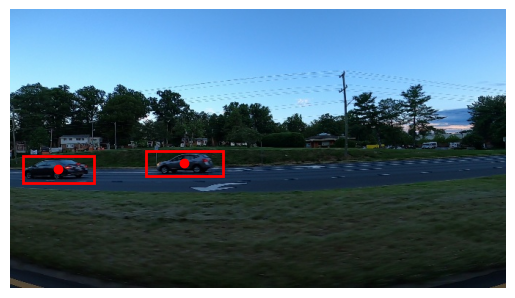

In [11]:
import os
import random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

csv_file = '/kaggle/input/data/train_solution_bounding_boxes (1).csv'
img_dir = '/kaggle/input/data/training_images'


# show a random image from the trainset with its bounding box 
def show_image(csv_file, img_dir):
    annotations = pd.read_csv(csv_file)
 
    img_dir = img_dir
    image_ids = annotations['image']
    
    random_number = random.randint(0, annotations.shape[0] - 1)
    print(f"image randomly chosen: {image_ids[random_number]}")
    
    image_id = image_ids[random_number]
    
    img_path = os.path.join(img_dir, image_id)
    image = Image.open(img_path).convert("RGB")
    
    # Step 3: Convert the tensor to a NumPy array
    img_numpy = np.array(image)
    
    boxes = annotations[annotations['image'] == image_id][['xmin', 'ymin', 'xmax', 'ymax']].values
    boxes = boxes.astype(float)
      
    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(img_numpy)
    
    for box in boxes:
        xmin, ymin, xmax, ymax = box  
        width = xmax - xmin
        height = ymax - ymin
        
        # Calculate the center point
        x_center = (xmin + xmax) / 2.0
        y_center = (ymin + ymax) / 2.0
        
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        # Plot the center point
        ax.plot(x_center, y_center, 'ro')  # 'bo' is for blue circle marker
    
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    plt.axis('off')  # Turn off axis
    plt.show()
    
show_image(csv_file, img_dir)

In [7]:
# DEBUGGING OPTIONS

# FIRST LEVEL OF GRANULARITY: IT SHOWS INPUT AND OUTPUT SIZES OF THE MAIN BLOCK OF THE ARCHITECTURE
DEBUG = True

# SECOND LEVEL OF GRANULARITY: IT SHOWS INPUT AND OUTPUT SIZES OF INTERNAL SUB-BLOCK TOO
DEBUG_2 = False

# Initialize dataset and dataloader

num_epochs = 1

csv_file = '/kaggle/input/data/train_solution_bounding_boxes (1).csv'
img_dir = '/kaggle/input/data/training_images'
transform = transforms.Compose([
    #data aug 
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

if DEBUG:
    print("========================================")
    print("        YOLOv8 Model Debug Output       ")
    print("========================================")
model = YOLO()

dataset = YOLODataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
bbox_loss_fn = nn.MSELoss()
cls_loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for images, targets in dataloader:
        images = images.to(device)
        
  
        bbox_targets = [t.to(device) for t in targets['boxes']]
        cls_targets = [t.to(device) for t in targets['labels']]

        optimizer.zero_grad()

        # Predizioni del modello
        outputs = model(images)
        
        
        # I think this should be fixed: higher grid size means more cells 
        # and so detection at a smaller size
        
        # the second indexing with 0 is used to take the element of the
        # batch since batch_size = 1
        large = outputs[0][0]
        
        medium = outputs[1][0]
        
        small = outputs[2][0]
        
        
        
        # SIZE OF THE OUTPUT:
        # (4 BBOX + 1 CONFIDENCE + 1 CLS) x GRID SIZE X GRID SIZE
        
        # COMPUTATION OF THE LOSS
        
        
        
        bbox_preds = [large_box, medium_box, small_box]
        cls_preds = [large_cls, medium_cls, small_cls]
        

        # Calcolo delle perdite
        bbox_loss = 0.0
        cls_loss = 0.0
       

        #for i in range(len(bbox_preds)):
            #bbox_loss += bbox_loss_fn(bbox_preds[i], bbox_targets[0])
            #cls_loss += cls_loss_fn(cls_preds[i], cls_targets[0].unsqueeze(1).float())

        total_loss = bbox_loss + cls_loss
        break
        
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}")

        YOLOv8 Model Debug Output       
---------- Backbone ----------
[Backbone Input]
Input Tensor Shape: torch.Size([1, 3, 128, 128])
[Layer: Conv 0]
Input Tensor Shape:  torch.Size([1, 3, 128, 128])
Output Tensor Shape: torch.Size([1, 64, 64, 64])
[Layer: Conv 1]
Input Tensor Shape:  torch.Size([1, 64, 64, 64])
Output Tensor Shape: torch.Size([1, 128, 32, 32])
[Layer: C2f 2]
Input Tensor Shape:  torch.Size([1, 128, 32, 32])
Output Tensor Shape: torch.Size([1, 128, 32, 32])
[Layer: Conv 3]
Input Tensor Shape:  torch.Size([1, 128, 32, 32])
Output Tensor Shape: torch.Size([1, 256, 16, 16])
[Layer: C2f 4]
Input Tensor Shape:  torch.Size([1, 256, 16, 16])
Output Tensor Shape: torch.Size([1, 256, 16, 16])
[Layer: Conv 5]
Input Tensor Shape:  torch.Size([1, 256, 16, 16])
Output Tensor Shape: torch.Size([1, 512, 8, 8])
[Layer: C2f 6]
Input Tensor Shape:  torch.Size([1, 512, 8, 8])
Output Tensor Shape: torch.Size([1, 512, 8, 8])
[Layer: Conv 7]
Input Tensor Shape:  torch.Size([1, 512, 8, 8

NameError: name 'large_box' is not defined